In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pdb

np.random.seed(0)

## Load Data

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'
data_raw = pd.read_csv(data_path)

## Explore Data

In [3]:
data_raw.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


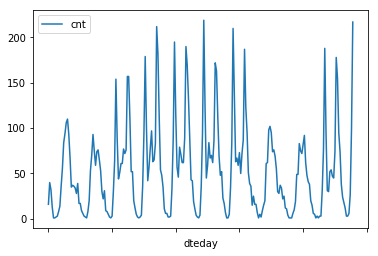

In [4]:
data_raw[:24*10].plot(x='dteday', y='cnt')

## Preprocess Data

Create Dummies

In [5]:
data = data_raw.copy()
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(data[each], prefix=each, drop_first=False)
    data = pd.concat([data, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = data.drop(fields_to_drop, axis=1)

In [6]:
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


Normalize

In [7]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

Split

In [8]:
# Convert to numpy
features = data.drop(['cnt', 'casual', 'registered'], axis=1).values
targets = data['cnt'].values[:,None]

N_t = len(features)
train_x, valid_x, test_x = np.split(features, [int(N_t*0.88815), int(N_t*0.971)])
train_y, valid_y, test_y = np.split(targets, [int(N_t*0.88815), int(N_t*0.971)])
train_i = np.array(range(len(train_x)))

In [9]:
print('train', train_x.shape, train_y.shape)
print('valid', valid_x.shape, valid_y.shape)
print('test', test_x.shape, test_y.shape)

train (15435, 56) (15435, 1)
valid (1440, 56) (1440, 1)
test (504, 56) (504, 1)


## Build Model

In [10]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    return sigmoid(x)*(1-sigmoid(x))

def MSE(y, y_hat):
    # no innner sum, becouse only one output
    return np.mean((y-y_hat)**2)

def fwd(x, W_hid, W_out):

    z_hid = x @ W_hid
    h_hid = sigmoid(z_hid)  # hidden output

    z_out = h_hid @ W_out
    y_hat = z_out  # linear output

    return y_hat, z_hid, h_hid

def backprop(x, y, W_hid, W_out):
    
    y_hat, z_hid, h_hid = fwd(x, W_hid, W_out)
    
    ro_out = (y-y_hat) * -1 # * -sigmoid_deriv(..), lin out!!
    dW_out = h_hid.T @ ro_out
    
    ro_hid = (ro_out @ W_out.T) * sigmoid_deriv(z_hid)
    dW_hid = x.T @ ro_hid
    
    return dW_hid, dW_out
    

## Train Loop

In [11]:
n_in = 56
n_hid = 12
n_out = 1
lr = 0.95
n_batch = 128
iterations = 1500

np.random.seed(0)

# Initialize weights
W_hid = np.random.normal(0.0, n_in**-.5, [n_in, n_hid])
W_out = np.random.normal(0.0, n_hid**-.5, [n_hid, n_out])


losses = {'train':[], 'valid':[]}
for i in range(iterations):
    
    # Get 128 sized batch, both as 2d arrays   
    batch = np.random.choice(train_i, n_batch)
    x = train_x[batch]
    y = train_y[batch]
    
    dW_hid, dW_out = backprop(x, y, W_hid, W_out)
        
    W_hid += -lr * dW_hid / n_batch
    W_out += -lr * dW_out / n_batch
    
    train_y_hat, _, _ = fwd(train_x, W_hid, W_out)
    train_loss = MSE(train_y, train_y_hat)
    losses['train'].append(train_loss)
    valid_y_hat, _, _ = fwd(valid_x, W_hid, W_out)
    valid_loss = MSE(valid_y, valid_y_hat)
    losses['valid'].append(valid_loss)
       
    

(0, 2)

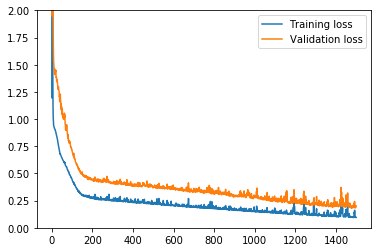

In [12]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['valid'], label='Validation loss')
plt.legend()
plt.ylim(0, 2)

In [14]:
W_hid[0:4]

array([[ 0.13977837,  0.39589006, -0.44433984, -0.23372222, -0.32673332,
        -0.31501645,  1.33654143, -0.66407594, -0.532159  , -0.42685932,
         0.27269841, -0.03363818],
       [ 0.48351939, -1.12272939,  0.13089203, -0.06550705,  0.17449842,
        -0.12881516, -0.66353395, -0.07265479, -0.007572  , -0.0190456 ,
        -0.10529271, -0.27215422],
       [ 0.20766098,  0.50374951, -0.47341402, -0.18073073, -0.22643633,
         0.372545  ,  0.16996664, -0.26835636, -1.22899995, -0.3707829 ,
         0.50471608, -0.19382687],
       [ 0.12652124, -0.07856539,  0.03382242, -0.10831552, -0.02563025,
        -0.32419792,  0.00803561,  0.48387678, -0.48559138, -0.17401633,
        -0.32882098,  0.01550563]])

Correct output:
```
array([[ 0.13977837,  0.39589006, -0.44433984, -0.23372222, -0.32673332,
        -0.31501645,  1.33654143, -0.66407594, -0.532159  , -0.42685932,
         0.27269841, -0.03363818],
       [ 0.48351939, -1.12272939,  0.13089203, -0.06550705,  0.17449842,
        -0.12881516, -0.66353395, -0.07265479, -0.007572  , -0.0190456 ,
        -0.10529271, -0.27215422],
       [ 0.20766098,  0.50374951, -0.47341402, -0.18073073, -0.22643633,
         0.372545  ,  0.16996664, -0.26835636, -1.22899995, -0.3707829 ,
         0.50471608, -0.19382687],
       [ 0.12652124, -0.07856539,  0.03382242, -0.10831552, -0.02563025,
        -0.32419792,  0.00803561,  0.48387678, -0.48559138, -0.17401633,
        -0.32882098,  0.01550563]])
```